In [1]:
!pip install -q matplotlib
!pip install -q numpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import threading
import time
import queue

from math import sin, cos
from scipy.integrate import solve_ivp

# **Introduction to PID Controllers for UAV Forge**
Welcome to the UAV Forge Drone Club's introductory notebook on PID controllers! In this guide, we'll dive deep into one of the fundamental concepts that allow our drones to fly smoothly and accurately: the PID control loop.

### **Why is PID Important for Drones?**
Our drones rely on precise and accurate movement. Whether we're hovering in place, moving in a specific direction, or rotating about an axis, we need the drone to respond to our commands while countering disturbances like wind. This is where PID controllers shine! They adjust the drone's motors in real time based on the difference between the desired setpoint (e.g., a specific altitude or angle) and the current state.

### **Components of PID**
*Proportional (P)*: Think of this as the immediate reaction. It looks at the present error and reacts proportionally. If the drone is tilted 10° from the desired angle, a higher P value would produce a stronger motor response than a lower one.

*Integral (I)*: This is the memory of the controller. It looks at past errors and tries to correct prolonged or consistent biases. If our drone consistently drifts to the left, the I term will work to counteract that drift over time.

*Derivative (D)*: The visionary. It predicts future errors by looking at the rate of change. If our drone is quickly approaching the desired altitude, the D term can slow it down to prevent overshooting.

# **1.1 Simple PID class**

In [3]:
class PID_Controller(object):

  def __init__(self, kp, ki, kd, target):
    self.kp = kp
    self.ki = ki
    self.kd = kd

    self.err = 0
    self.prev_err = 0
    self.integral_sum = 0
    self.derivative = 0

    self.target = target

    self.step = 0

  def calculate_u(self, input):

    assert type(self.target) != None, 'havent set PID controller target angle, use class method set_point(target)'

    self.prev_err = self.err
    self.err = self.target - input
    self.integral_sum += self.err
    self.derivative = self.err - self.prev_err

    return self.kp*self.err + self.ki*self.integral_sum + self.kd*self.derivative



  def reset(self):
    print(f'resetting integral derivative and error values (not gain values k)')
    self.err = 0
    self.prev_err = 0
    self.integral_sum = 0
    self.step = 0

# Planar Quadrotor (2D)


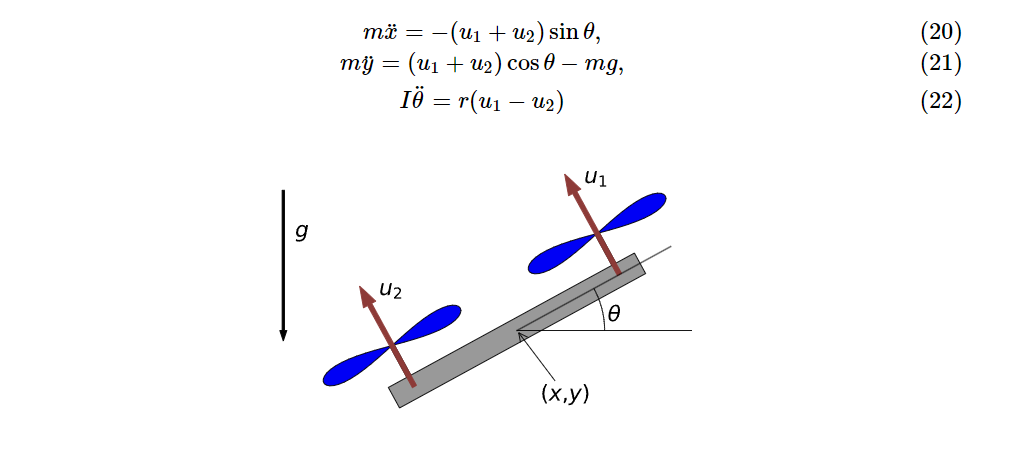

## ArduPilot Positional Controller (XYZ)

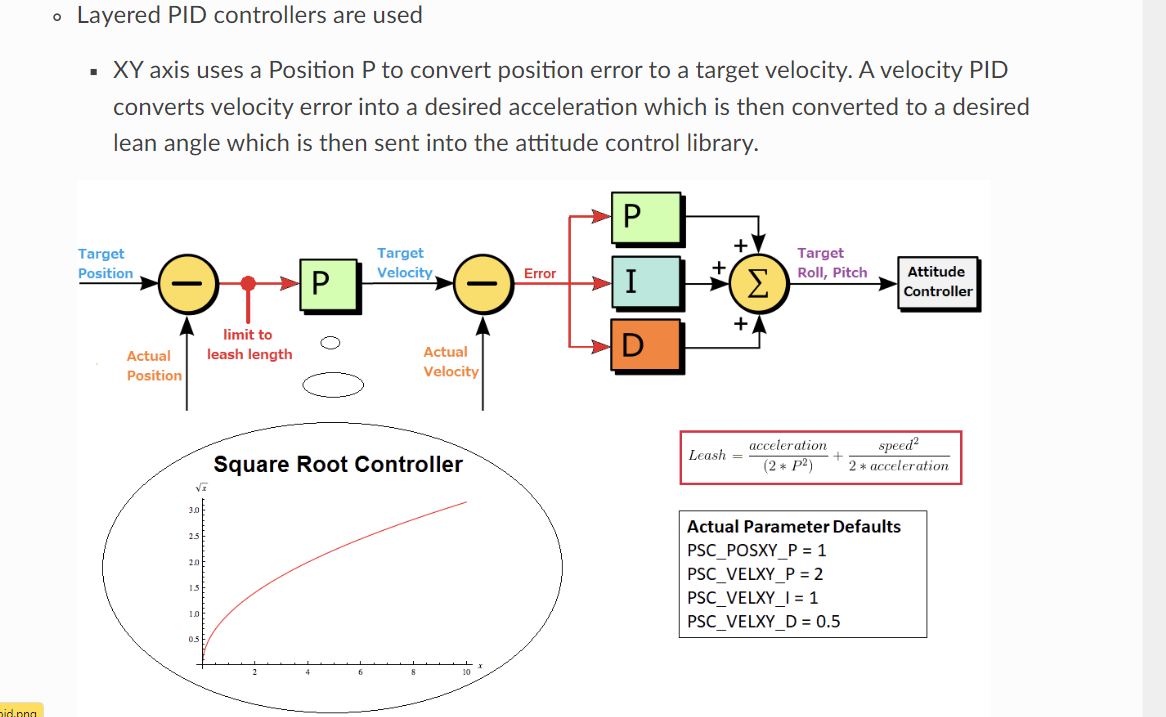

# How do they convert X Y axis acceloration into a target angle?
------------------------------------------------------------------

##Lets revisit the equations of motion

\begin{align}
m \ddot{x} &= (u_1 + u_2) \sin(\theta) \\
m \ddot{y} &= (u_1 + u_2) \cos(\theta) - mg \\
I \ddot{\theta} &= r(u_1 - u_2)
\end{align}

###Consider the first two equations

\begin{align}
m \ddot{x} &= (u_1 + u_2) \sin(\theta) \\
m \ddot{y} &= (u_1 + u_2) \cos(\theta) - mg \\
\end{align}

###Add mg to both sides

\begin{align}
m \ddot{x} &= (u_1 + u_2) \sin(\theta) \\
m \ddot{y} + mg &= (u_1 + u_2) \cos(\theta) \\
\end{align}

### And once we divide the acceloration components
\begin{align}
\frac{m \ddot{x}}{m \ddot{y} + mg} &= \frac{(u_1 + u_2) \sin(\theta)}{(u_1 + u_2) \cos(\theta)} = \tan(\theta)
\end{align}

###Therefore

\begin{align}
\frac{m \ddot{x}}{m \ddot{y} + mg} = \tan(\theta) \\
\arctan(\frac{\ddot{x}/\ddot{y}}{g}) = \theta
\end{align}


## Lets see exactly whats in ardupilot

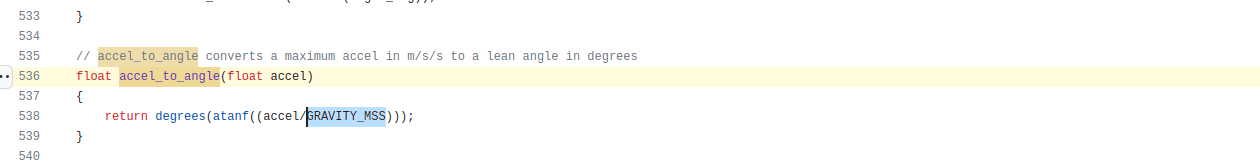

## ArduPilot Attitude Control (Pitch Roll Yaw)

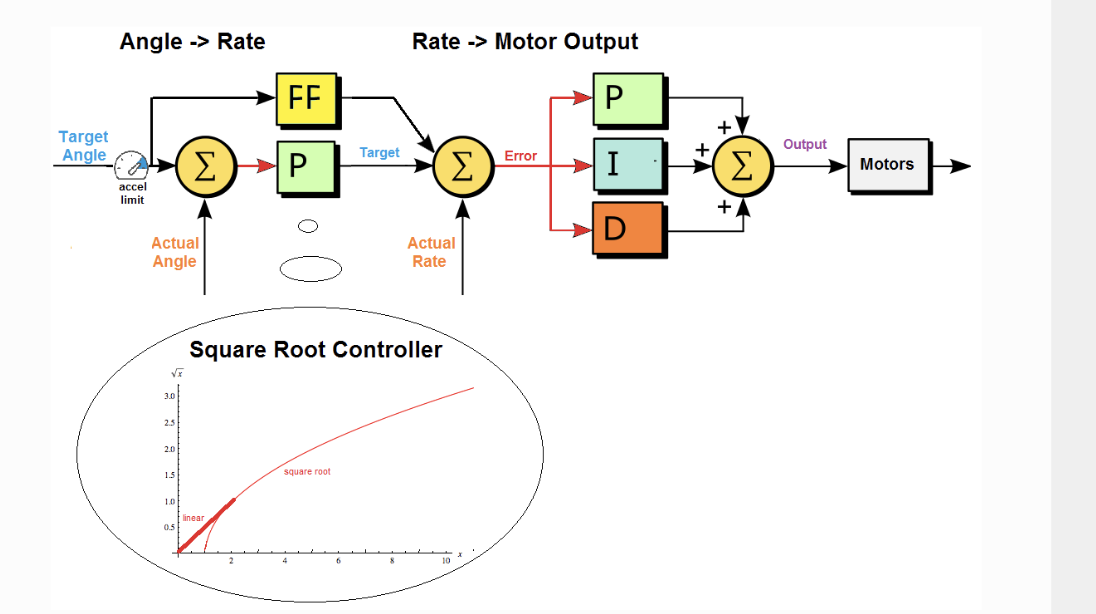

In [4]:
import math

class ArduPilot2D_PID:

  def __init__(self, targetxy):

    self.I_xx = 0.00025 # Mass moment of inertia (kg*m^2)
    self.m = 0.18
    self.L = 0.086

    self.setpoint = targetxy

    self.x_P = PID_Controller(kp=2.0, ki=0, kd=0, target=self.setpoint[0])
    self.y_P = PID_Controller(kp=5.0, ki=0, kd=0, target=self.setpoint[1])

    self.x_PID = PID_Controller(kp=2.0, ki=0, kd=0, target=None)
    self.y_PID = PID_Controller(kp=1.0, ki=1.0, kd=0, target=None)

    self.theta_P = PID_Controller(kp=2.0, ki=0, kd=0, target=None)
    self.theta_PID = PID_Controller(kp=2.0, ki=0, kd=0, target=None)

    self.reference_xv = []
    self.reference_yv = []

    self.reference_theta = []
    self.reference_thetav = []

    self.U1 = []
    self.U2 = []



  def __call__(self, t, state):

    cur_x, cur_y, cur_theta = state[0], state[1], state[2]
    cur_xdot, cur_ydot, cur_thetadot = state[3], state[4], state[5]

    #Positional Control

    target_vel_x, target_vel_y = self.x_P.calculate_u(input=cur_x), self.y_P.calculate_u(input=cur_y) #Get velocities from P controller for position

    self.reference_xv.append(target_vel_x)
    self.reference_yv.append(target_vel_y)
    self.x_PID.target = target_vel_x #Set the velocities from P controller to target of velocity controller x
    self.y_PID.target = target_vel_y #Set the velocities from P controller to target of velocity controller y
    target_acc_x, target_acc_y =  self.x_PID.calculate_u(input=cur_xdot),  self.y_PID.calculate_u(input=cur_ydot) #Find optimal rate of velocity (acceloration) to get to velocity setpoint.

    #Convert accelorations to target angle
    target_theta = math.degrees(math.atan(math.radians((target_acc_x / target_acc_y) / 9.81))) #accelorations divided by g, the acceloration of gravity 9.81m/s

    #max_theta = math.radians(30)  # 30 degrees to radians as an example
    #target_theta = max(-max_theta, min(target_theta, max_theta))
    self.reference_theta.append(target_theta)

    #Attitude Control
    self.theta_P.target = target_theta
    theta_dot = self.theta_P.calculate_u(input=cur_theta) #Find target ang velocity
    self.reference_thetav.append(theta_dot)

    self.theta_PID.target=theta_dot
    target_acc_theta = self.theta_PID.calculate_u(input=cur_thetadot) #Find target ang acceloration

    #Use knows to solve for u1 and u2

    u1 = self.m*9.81 + self.m*target_acc_y
    u2 = self.I_xx * target_acc_theta

    F = u1 + u2
    M = (u2 - u1)*self.L

    u1 = 0.5*(F - M/self.L)
    u2 = 0.5*(F + M/self.L)

    #if u1 < 0 or u1 > 1.7658 or u2 < 0 or u2 > 1.7658:
    #    print(f'motor saturation {u1} {u2}')

    u1_clamped = min(max(0, u1), 1.7658)
    u2_clamped = min(max(0, u2), 1.7658)

    self.U1.append(u1_clamped)
    self.U2.append(u2_clamped)
    F_clamped = u1_clamped + u2_clamped
    M_clamped = (u2_clamped - u1_clamped) * self.L

    accelx = -F_clamped * math.degrees(sin(math.radians(cur_theta))) / self.m
    accely = F_clamped * math.degrees(cos(math.radians(cur_theta))) / self.m - 9.81
    acceltheta = M_clamped / self.I_xx


    # Ground contact model
    if cur_y <= -1:
        # Prevent further downward movement if on the ground
        accely = max(accely, 0)
        cur_ydot = max(cur_ydot, 0)
        cur_y = max(cur_y, 0)  # Ensure the quadrotor does not go below the ground level


    return [cur_xdot, cur_ydot, cur_thetadot, accelx, accely, acceltheta]

  def clear_saved_memory(self):
    self.reference_xv = []
    self.reference_yv = []

    self.reference_theta = []
    self.reference_thetav = []
    print('RESET MEMORY OF REFERENCE xv yv theta thetav')







# Lets try this on our 2D Quad

In [5]:
from scipy.integrate import solve_ivp

# Assuming your PID_Controller class is correctly implemented and available in the scope

# Define the initial conditions of the quadrotor
# Let's say the initial conditions are [x, y, theta, x_dot, y_dot, theta_dot]
initial_conditions = [0, 2, 0, 0, 0.1, 0]

# Define the time span for the simulation: from 0 to 10 seconds
time_span = [0, 10]

# Define the target position for the quadrotor, let's say (1, 1)
target_position = [1, 10]

# Create an instance of the ArduPilot2D_PID class
quadrotor_pid = ArduPilot2D_PID(targetxy=target_position)


n_steps = time_span[1] #number of steps equals number of seconds in time span.
# Integrate the system using solve_ivp
solution = solve_ivp(
    fun=quadrotor_pid,
    t_span=time_span,
    y0=initial_conditions,
    method='RK45',
    t_eval=np.linspace(time_span[0], time_span[1], n_steps)
)

# The solution object now contains the time points and the states at those time points
# solution.t is an array of time points
# solution.y is an array where each column corresponds to the state vector at a time point

x_positions = solution.y[0]
y_positions = solution.y[1]
theta = solution.y[2]
x_velocities = solution.y[3]
y_velocities = solution.y[4]
theta_velocities = solution.y[5]

times = solution.t


# Plotting Helper Functions

In [6]:
def side_by_side(x, y1, y2, plot1_names, plot2_names):

  """
  x is the time from solution.x
  y1 is the y values for the left side plot
  y2 is the y values for right side plot

  plot[i]_names is a list [plot[i]_title : str, plot[i]_xaxis_name : str, plot[i]_yaxis_name]

  """

  title1, xlabel1, ylabel1= plot1_names[0], plot1_names[1], plot1_names[2]
  title2, xlabel2, ylabel2= plot2_names[0], plot2_names[1], plot2_names[2]
  # Create a figure with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) # figsize is optional

  # Plot on the first axis
  ax1.plot(x, y1, color='orange', label=ylabel1)
  ax1.set_title(title1)
  ax1.set_xlabel(xlabel1)
  ax1.set_ylabel(ylabel1)

  # Plot on the second axis
  ax2.plot(x, y2, color='green', label=ylabel2)
  ax2.set_title(title2)
  ax2.set_xlabel(xlabel2)
  ax2.set_ylabel(ylabel2)

  # Automatically adjust the subplot layout for a nicer fit
  plt.tight_layout()

  return fig, ax1, ax2



##Positional P Control Plot X and Y

In [ ]:
labels_plot1 = ['position [x] over time', 'time [s]', 'x [m]']
labels_plot2 = ['position [y] over time', 'time [s]', 'y [m]']

positional_plots, plot1, plot2 = side_by_side(times, x_positions, y_positions, labels_plot1, labels_plot2)
plot1.plot(times[-1], target_position[0], marker='o', markersize=5, color='red', label='target')
plot1.legend()
plot2.plot(times[-1], target_position[1], marker='o', markersize=5, color='red',label='target')
plot2.legend()
positional_plots.show()

Velocity PID Control X Y

In [ ]:
labels_plot1 = ['velocity [xv] over time', 'time [s]', 'xv [m/s]']
labels_plot2 = ['velocity [xv] over time', 'time [s]', 'yv [m/s]']

reference_xv, reference_yv = quadrotor_pid.reference_xv, quadrotor_pid.reference_yv
xv_interval, yv_interval = int(len(reference_xv) / times[-1]), int(len(reference_yv) / times[-1])
print(xv_interval, type(xv_interval))
xv_intervals, yv_intervals = [idx*int(xv_interval) for idx in range(0, int(times[-1]))], [idx*int(yv_interval) for idx in range(0, int(times[-1]))]

xv_references, yv_references = [reference_xv[xv_idx] for xv_idx in xv_intervals if xv_idx < len(reference_xv)], [reference_yv[yv_idx] for yv_idx in yv_intervals if yv_idx < len(reference_yv)]

positional_plots, plot1, plot2 = side_by_side(times, x_velocities, y_velocities, labels_plot1, labels_plot2)
plot1.plot(np.arange(0, len(xv_references)), xv_references, marker='^', linestyle='-', markersize=3, color='red', label='target vel')
plot1.legend()
plot2.plot(np.arange(0, len(yv_references)), yv_references, marker='^', linestyle='-', markersize=3, color='red',label='target vel')
plot2.legend()
positional_plots.show()

## Attitude angle Plot

In [ ]:
labels_plot1 = ['angle [theta] over time', 'time [s]', 'theta [deg]']
labels_plot2 = ['angular rate [thetav] over time', 'time [s]', 'thetav [deg/s]']

#    self.reference_theta = []
#    self.reference_thetav = []

# Setting reference values for theta and thetav
reference_theta, reference_thetav = quadrotor_pid.reference_theta, quadrotor_pid.reference_thetav

# Calculating intervals
theta_interval = int(len(reference_theta) / times[-1])
thetav_interval = int(len(reference_thetav) / times[-1])

# Generating intervals lists for theta and thetav
theta_intervals = [idx*int(theta_interval) for idx in range(0, int(times[-1]))]
thetav_intervals = [idx*int(thetav_interval) for idx in range(0, int(times[-1]))]

# Generating references for theta and thetav
theta_references = [reference_theta[theta_idx] for theta_idx in theta_intervals if theta_idx < len(reference_theta)]
thetav_references = [reference_thetav[thetav_idx] for thetav_idx in thetav_intervals if thetav_idx < len(reference_thetav)]

# Plotting
positional_plots, plot1, plot2 = side_by_side(range(0, len(theta_references)), theta_references, thetav_references, labels_plot1, labels_plot2)
plot1.plot(times, theta_references, marker='o', linestyle='dashed', markersize=5, color='red', label='target theta')
plot1.legend()
plot2.plot(times, thetav_references, marker='o', linestyle='dashed', markersize=5, color='red', label='target thetav')
plot2.legend()
positional_plots.show()


## Actuations

In [ ]:
labels_plot1 = ['Control Input U1 over time', 'time [s]', 'U1 [unit]']
labels_plot2 = ['Control Input U2 over time', 'time [s]', 'U2 [unit]']

# Extracting U1 and U2 values from quadrotor_pid
U1, U2 = quadrotor_pid.U1, quadrotor_pid.U2

# Calculating intervals for U1 and U2
U1_interval = int(len(U1) / times[-1])
U2_interval = int(len(U2) / times[-1])

# Generating intervals lists for U1 and U2
U1_intervals = [idx * U1_interval for idx in range(0, int(times[-1]))]
U2_intervals = [idx * U2_interval for idx in range(0, int(times[-1]))]

# Generating references for U1 and U2
U1_references = [U1[u1_idx] for u1_idx in U1_intervals if u1_idx < len(U1)]
U2_references = [U2[u2_idx] for u2_idx in U2_intervals if u2_idx < len(U2)]

# Plotting
control_plots, plot1, plot2 = side_by_side(times, U1_references, U2_references, labels_plot1, labels_plot2)

control_plots.show()
